#Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

  sys.path.append('/content/drive/My Drive/Colab Notebooks/')
  %cd /content/drive/My Drive/Colab Notebooks/
  부분에 적절한 colab drive 경로를 설정해주어야 합니다.

In [ ]:
import sys, os
!ls

if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  sys.path.append('/content/drive/My Drive/Colab Notebooks/')
  %cd /content/drive/My Drive/Colab Notebooks/

  !pip install gym
  !apt-get install -y xvfb
  !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb
  !apt-get install -y python-opengl ffmpeg
  !pip install pyglet==1.5.0


# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

drive  sample_data  xvfb.pid
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
--2022-04-06 10:37:17--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640 [text/plain]
Saving to: ‘../xvfb’

../xvfb             100%[===================>]     640  --.-KB/s    in 0s      

2022-04-06 10:37:17 (43.8 MB/s) - ‘../xvfb’ saved [640/640]

Reading package lists

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [ ]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [ ]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        print(action)
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(4, 4, False)
1
(7, 4, False)
0
End game! Reward:  1.0
You won :)

(9, 8, False)
1
(19, 8, False)
1
(20, 8, False)
1
End game! Reward:  -1.0
You lost :(

(18, 3, True)
0
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [ ]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [ ]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((15, 6, False), 1, 0.0), ((17, 6, False), 1, 0.0), ((19, 6, False), 0, 1.0)]
[((15, 10, False), 1, -1.0)]
[((13, 4, False), 1, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [ ]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # Generate episode
        episode = generate_episode(env)
        # extract states, actions & rewards
        state_list, action_list, reward_list = zip(*episode)
        # implement discount
        discount = np.array([gamma**i for i in range(len(reward_list)+1)])
        # calculate and store the return for each visit in the episode
        for i,state in enumerate(state_list):
            returns[state].append(sum(reward_list[i:]*discount[:-(i+1)]))
    # calculate the state-value function estimate
    V = {k: np.mean(v) for k, v in returns.items()}
    return V

In [ ]:
print(V)

{(13, 6, False): -0.40924956369982546, (18, 6, False): -0.6166634448095882, (21, 6, False): 0.9070185962807439, (15, 7, False): -0.4958133971291866, (13, 3, False): -0.4455723542116631, (20, 3, False): 0.6463017960684486, (7, 1, False): -0.5448979591836735, (17, 1, False): -0.675601103665747, (16, 2, False): -0.5632571996027805, (20, 2, False): 0.6358406443261901, (16, 4, False): -0.5534727703235991, (19, 4, False): 0.4386873920552677, (18, 10, False): -0.6775343622460946, (6, 10, False): -0.4793359237018721, (15, 10, False): -0.5919857976160284, (20, 10, False): 0.42776395307500886, (14, 9, False): -0.4672544080604534, (21, 6, True): 0.9051948051948052, (13, 7, True): 0.033482142857142856, (15, 7, True): -0.13857677902621723, (17, 7, True): -0.18512898330804248, (18, 7, True): -0.23026315789473684, (18, 7, False): -0.5920463032113518, (19, 10, False): -0.027469372128637058, (16, 10, False): -0.6153202794450457, (11, 10, False): -0.01688048615800135, (21, 10, False): 0.8867240598096964

Use the cell below to calculate and plot the state-value function estimate.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)


Episode 500000/500000.

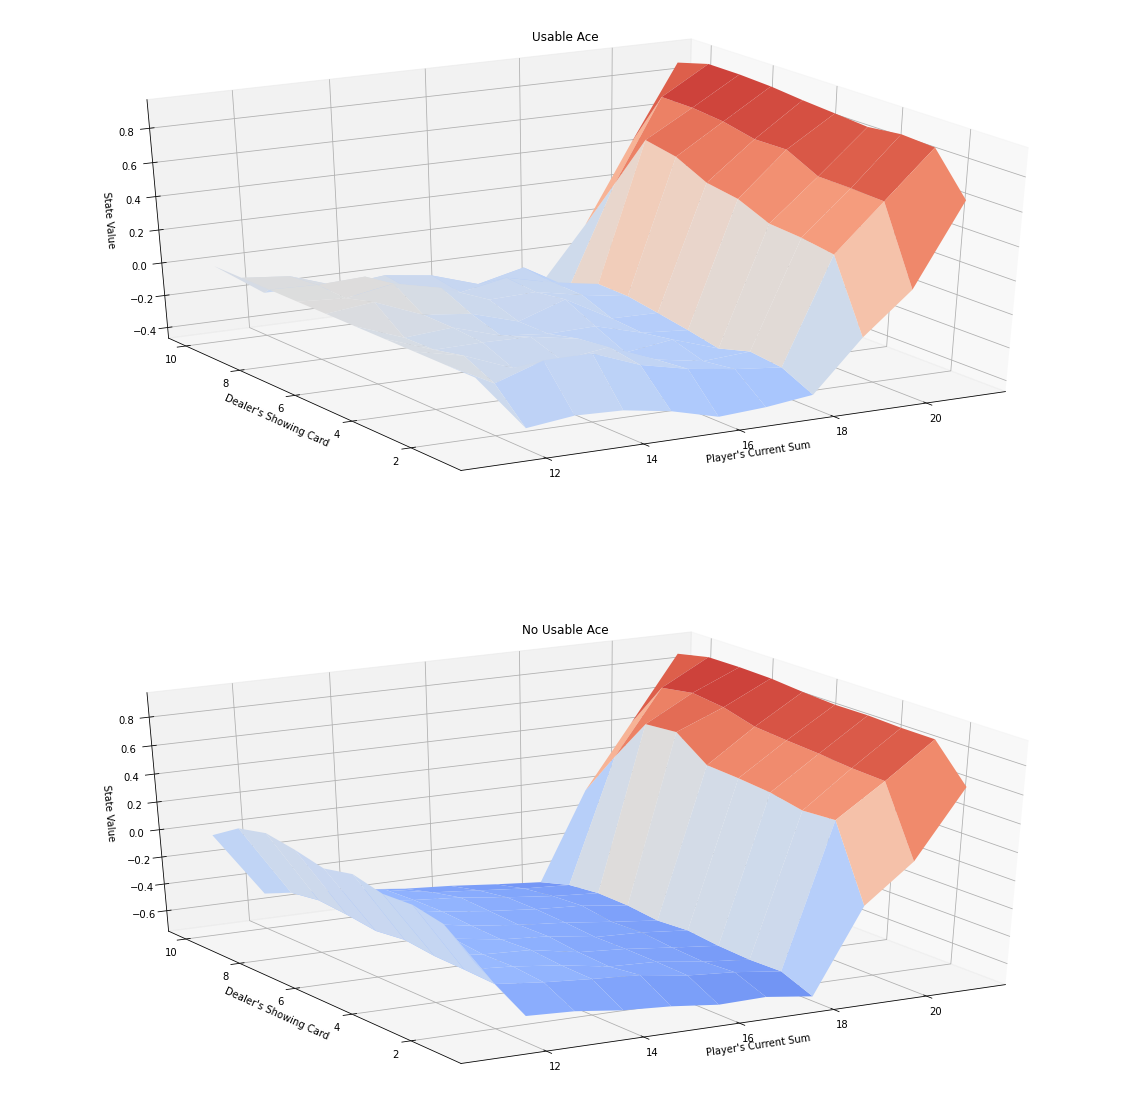

In [ ]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
type(env.action_space)

gym.spaces.discrete.Discrete

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    #V = mc_prediction_v(env, num_episodes, generate_episode, gamma)
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate episode
        episode = generate_episode(env)
        # extract states, actions & rewards
        state_list, action_list, reward_list = zip(*episode)
        # implement discount
        discount = np.array([gamma**i for i in range(len(reward_list)+1)])
        # calculate and store the return for each visit in the episode
        for i, state in enumerate(state_list):
            Q[state][action_list[i]] += sum(reward_list[i:]*discount[:-(i+1)])
            N[state][action_list[i]] += 1
    # calculate the state-value function estimate
    for k, v in Q.items():
        for action in [0, 1]:
            if N[k][action] != 0:
                Q[k][action] = Q[k][action] / N[k][action]
    return Q

In [ ]:
Q_test = mc_prediction_q(env, 10, generate_episode_from_limit_stochastic)

In [ ]:
print(Q_test)

defaultdict(<function mc_prediction_q.<locals>.<lambda> at 0x7ff012283290>, {(16, 7, False): array([ 0., -1.]), (15, 1, False): array([ 0., -1.]), (19, 1, False): array([-1.,  0.]), (8, 3, False): array([ 0., -1.]), (13, 3, False): array([ 0., -1.]), (15, 3, False): array([ 0., -1.]), (13, 10, False): array([0., 1.]), (19, 10, False): array([1., 0.]), (18, 6, False): array([ 0., -1.]), (19, 6, False): array([1., 0.]), (21, 6, True): array([0., 0.]), (13, 2, False): array([-1.,  0.]), (14, 5, False): array([0., 1.]), (15, 5, False): array([0., 1.]), (16, 5, False): array([1., 0.]), (20, 5, False): array([1., 0.])})


Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.


Episode 500000/500000.

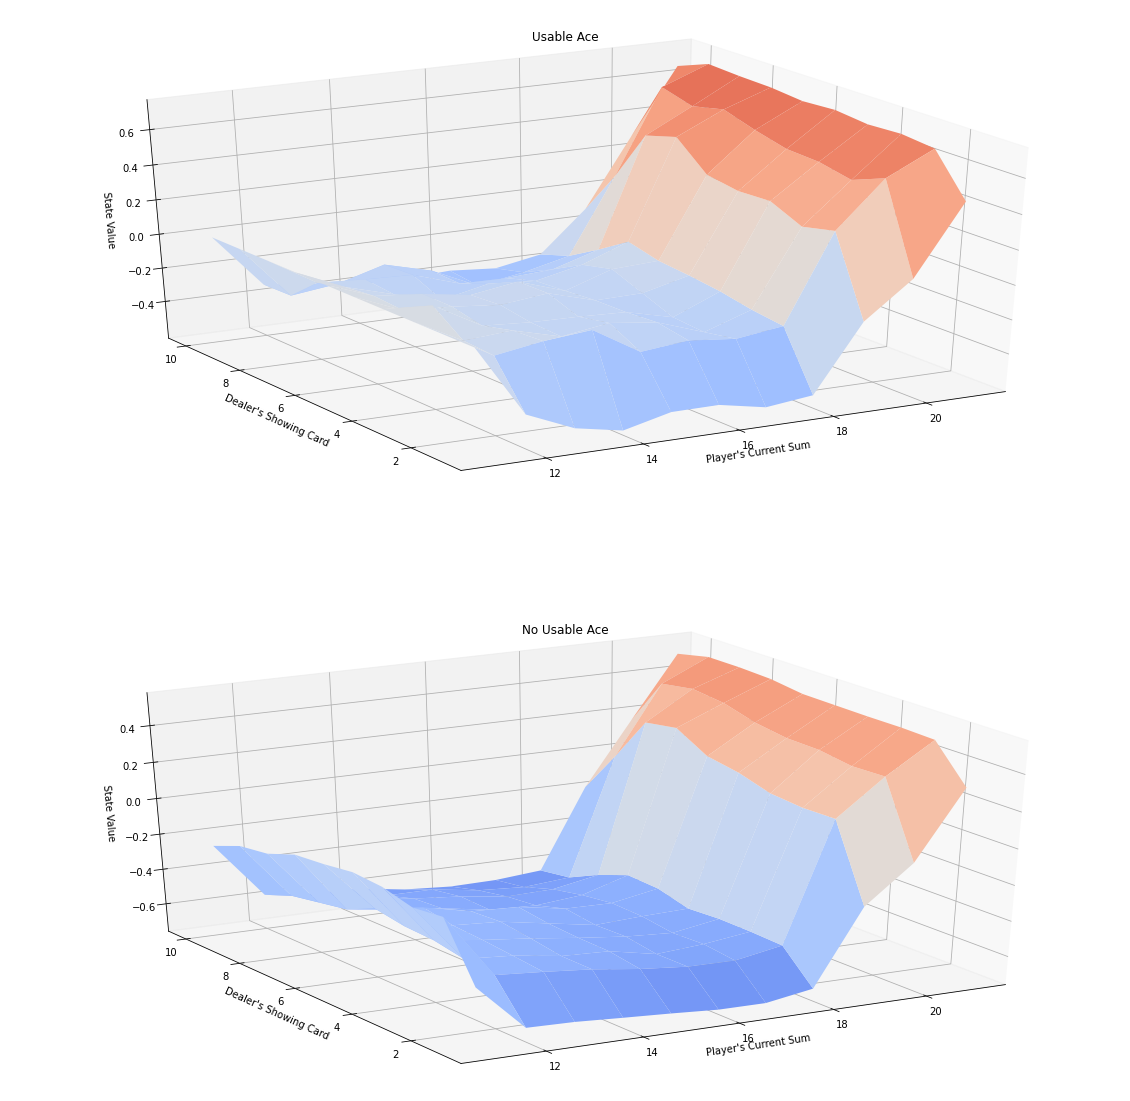

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [ ]:
print(Q)

defaultdict(<function mc_prediction_q.<locals>.<lambda> at 0x7ff01221fdd0>, {(20, 10, False): array([ 0.43638431, -0.88596846]), (20, 3, False): array([ 0.64591897, -0.89617486]), (19, 10, False): array([-0.02257952, -0.78667031]), (16, 3, False): array([-0.29754959, -0.62825595]), (21, 3, False): array([ 0.89, -1.  ]), (15, 10, False): array([-0.58074447, -0.65301391]), (20, 5, False): array([ 0.67070026, -0.84227642]), (6, 1, False): array([-0.81081081, -0.5915493 ]), (17, 7, False): array([-0.11363636, -0.64434565]), (21, 7, False): array([ 0.92705988, -1.        ]), (6, 3, False): array([-0.13636364, -0.34414414]), (20, 2, False): array([ 0.65043976, -0.88826367]), (13, 9, False): array([-0.59009009, -0.53267327]), (18, 9, False): array([-0.21691974, -0.7022715 ]), (14, 10, False): array([-0.56115726, -0.6077352 ]), (13, 6, False): array([-0.14319249, -0.46241783]), (15, 6, False): array([-0.09639954, -0.56053068]), (17, 1, False): array([-0.63542857, -0.75860171]), (13, 1, True): 

교수님이 구하신 V 대로 계산하면 결과가 같은가

Episode 500000/500000.

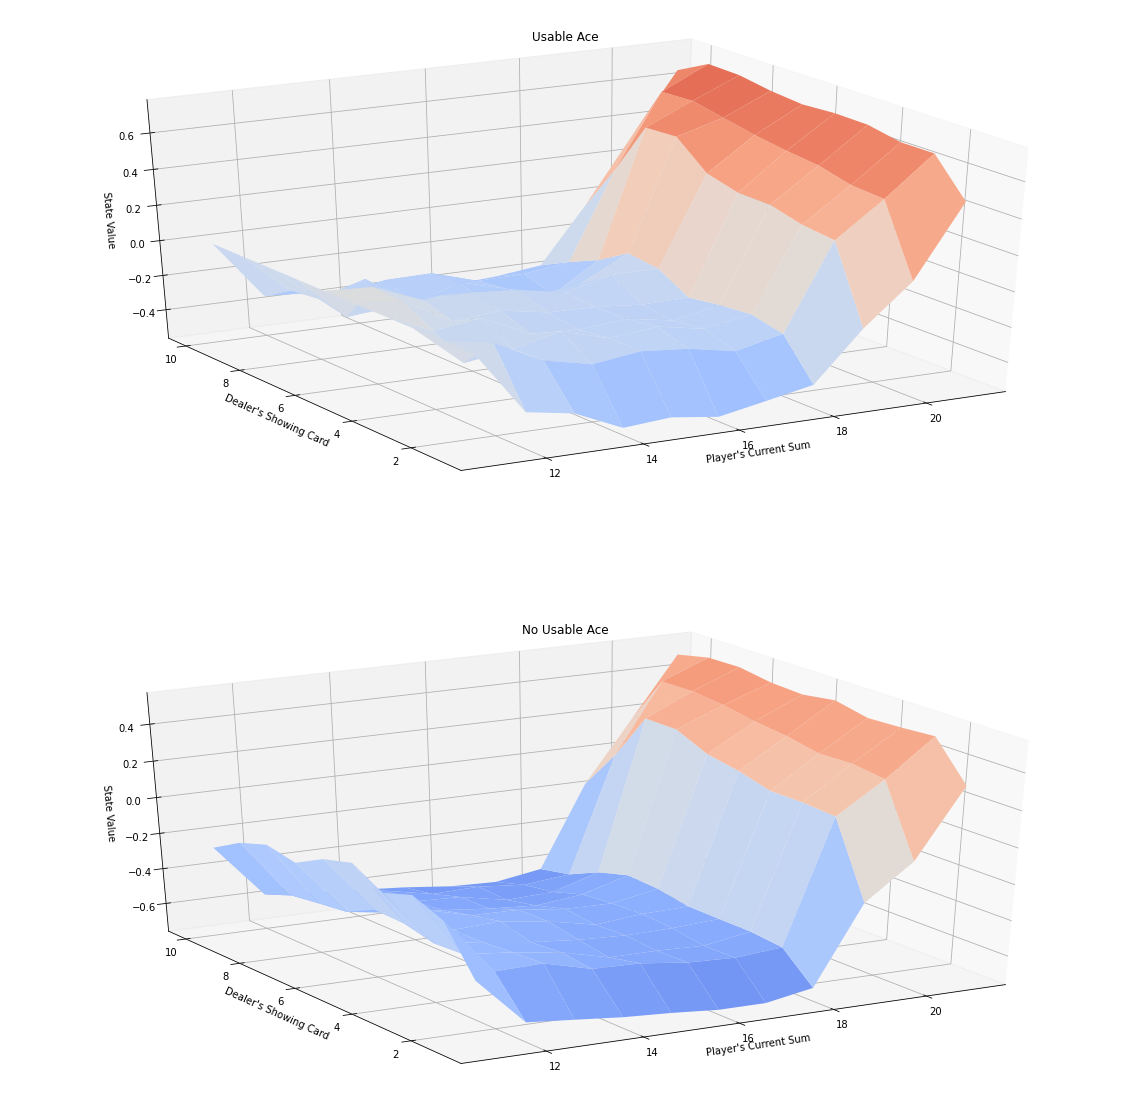

In [ ]:
# obtain the value function
V_test = mc_prediction_v(env, 500000, generate_episode_from_limit_stochastic)

# plot the value function
plot_blackjack_values(V_test)

거의 똑같다

### Part 3: MC Control: GLIE

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q_GLIE(env, episode, Q, N, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        N[state][actions[i]] += 1
    return Q, N

def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

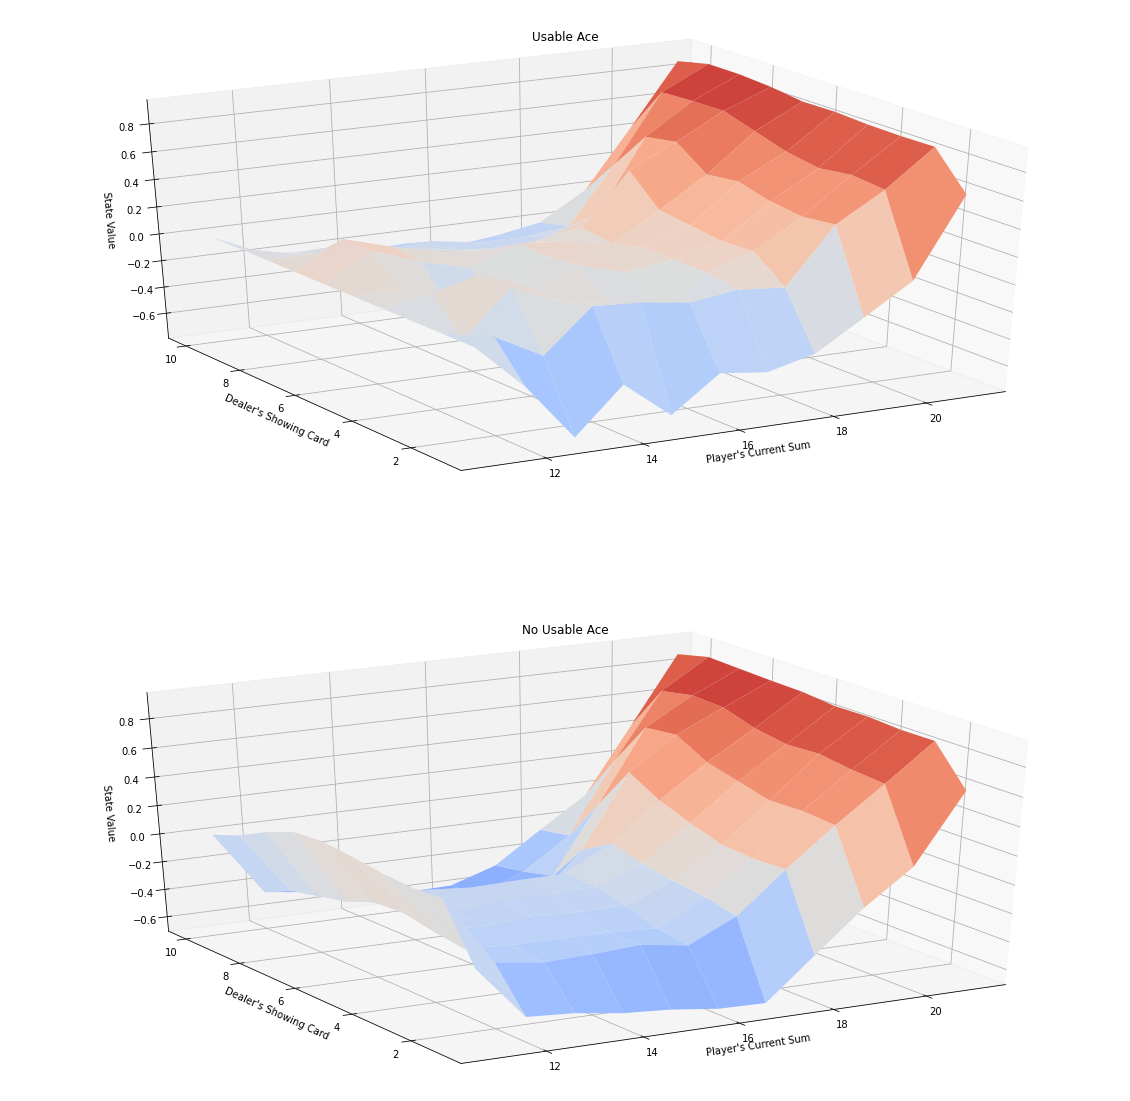

In [ ]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

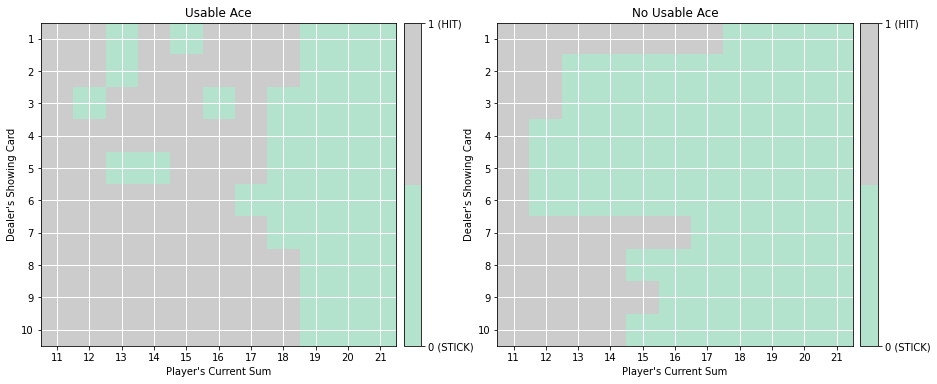

In [ ]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](https://github.com/harshitandro/OpenAI-Gym-BlackjackEnv/blob/master/Monte_Carlo/images/optimal.png?raw=1)

전체적인 경향성 -STICK 해야할 때와 HIT 해야할 때의 구분선과 영역- 은 optimal policy에 있지만, 약간의 오차가 있다. 예를 들어 직선으로 떨어져야 하는 경계에서 울퉁불퉁하게 policy가 나오며 optimal과는 다른 모습을 보여주는 구간이 있다.

In [ ]:
# 불가능한 상황
policy_glie[(11, 1, True)]

KeyError: ignored

Usable ace가 있는데 player sum은 11일 수 없다.

아래에서 optimal 과 비교하려는데 알아낸 것이다. 50만번을 해도 ace를 가진 경우는 생각보다 그렇게 많지가 않아서 데이터가 잘 없다. 특히 양 끝으로 가면 데이터가 없다. 그래서 위와 같이 찾아내려고 하면 안나온다.
실제로 plot_policy에서도 있으면 그 값을 내어 놓지만 없으면 else 일때 (42행) 그냥 1을 결론으로 가져온다. 따라서 data를 늘려야 한다.

In [ ]:
# 정확한 규칙을 찾아서 구현해서 넣기는 어려우니까 일단 그냥 값으로 만들어 넣었다.
optimal_policy = {
    (21, 1, True) : 0, (21, 2, True) : 0, (21, 3, True) : 0, (21, 4, True) : 0, (21, 5, True) : 0, (21, 6, True) : 0, (21, 7, True) : 0, (21, 8, True) : 0, (21, 9, True) : 0, (21, 10, True) : 0,
    (20, 1, True) : 0, (20, 2, True) : 0, (20, 3, True) : 0, (20, 4, True) : 0, (20, 5, True) : 0, (20, 6, True) : 0, (20, 7, True) : 0, (20, 8, True) : 0, (20, 9, True) : 0, (20, 10, True) : 0,
    (19, 1, True) : 0, (19, 2, True) : 0, (19, 3, True) : 0, (19, 4, True) : 0, (19, 5, True) : 0, (19, 6, True) : 0, (19, 7, True) : 0, (19, 8, True) : 0, (19, 9, True) : 0, (19, 10, True) : 0,
    (18, 1, True) : 1, (18, 2, True) : 0, (18, 3, True) : 0, (18, 4, True) : 0, (18, 5, True) : 0, (18, 6, True) : 0, (18, 7, True) : 0, (18, 8, True) : 0, (18, 9, True) : 1, (18, 10, True) : 1,
    (17, 1, True) : 1, (17, 2, True) : 1, (17, 3, True) : 1, (17, 4, True) : 1, (17, 5, True) : 1, (17, 6, True) : 1, (17, 7, True) : 1, (17, 8, True) : 1, (17, 9, True) : 1, (17, 10, True) : 1,
    (16, 1, True) : 1, (16, 2, True) : 1, (16, 3, True) : 1, (16, 4, True) : 1, (16, 5, True) : 1, (16, 6, True) : 1, (16, 7, True) : 1, (16, 8, True) : 1, (16, 9, True) : 1, (16, 10, True) : 1,
    (15, 1, True) : 1, (15, 2, True) : 1, (15, 3, True) : 1, (15, 4, True) : 1, (15, 5, True) : 1, (15, 6, True) : 1, (15, 7, True) : 1, (15, 8, True) : 1, (15, 9, True) : 1, (15, 10, True) : 1,
    (14, 1, True) : 1, (14, 2, True) : 1, (14, 3, True) : 1, (14, 4, True) : 1, (14, 5, True) : 1, (14, 6, True) : 1, (14, 7, True) : 1, (14, 8, True) : 1, (14, 9, True) : 1, (14, 10, True) : 1,
    (13, 1, True) : 1, (13, 2, True) : 1, (13, 3, True) : 1, (13, 4, True) : 1, (13, 5, True) : 1, (13, 6, True) : 1, (13, 7, True) : 1, (13, 8, True) : 1, (13, 9, True) : 1, (13, 10, True) : 1,
    (12, 1, True) : 1, (12, 2, True) : 1, (12, 3, True) : 1, (12, 4, True) : 1, (12, 5, True) : 1, (12, 6, True) : 1, (12, 7, True) : 1, (12, 8, True) : 1, (12, 9, True) : 1, (12, 10, True) : 1,
    (11, 1, True) : 1, (11, 2, True) : 1, (11, 3, True) : 1, (11, 4, True) : 1, (11, 5, True) : 1, (11, 6, True) : 1, (11, 7, True) : 1, (11, 8, True) : 1, (11, 9, True) : 1, (11, 10, True) : 1,

    (21, 1, False) : 0, (21, 2, False) : 0, (21, 3, False) : 0, (21, 4, False) : 0, (21, 5, False) : 0, (21, 6, False) : 0, (21, 7, False) : 0, (21, 8, False) : 0, (21, 9, False) : 0, (21, 10, False) : 0,
    (20, 1, False) : 0, (20, 2, False) : 0, (20, 3, False) : 0, (20, 4, False) : 0, (20, 5, False) : 0, (20, 6, False) : 0, (20, 7, False) : 0, (20, 8, False) : 0, (20, 9, False) : 0, (20, 10, False) : 0,
    (19, 1, False) : 0, (19, 2, False) : 0, (19, 3, False) : 0, (19, 4, False) : 0, (19, 5, False) : 0, (19, 6, False) : 0, (19, 7, False) : 0, (19, 8, False) : 0, (19, 9, False) : 0, (19, 10, False) : 0,
    (18, 1, False) : 0, (18, 2, False) : 0, (18, 3, False) : 0, (18, 4, False) : 0, (18, 5, False) : 0, (18, 6, False) : 0, (18, 7, False) : 0, (18, 8, False) : 0, (18, 9, False) : 0, (18, 10, False) : 0,
    (17, 1, False) : 0, (17, 2, False) : 0, (17, 3, False) : 0, (17, 4, False) : 0, (17, 5, False) : 0, (17, 6, False) : 0, (17, 7, False) : 0, (17, 8, False) : 0, (17, 9, False) : 0, (17, 10, False) : 0,
    (16, 1, False) : 1, (16, 2, False) : 0, (16, 3, False) : 0, (16, 4, False) : 0, (16, 5, False) : 0, (16, 6, False) : 0, (16, 7, False) : 1, (16, 8, False) : 1, (16, 9, False) : 1, (16, 10, False) : 1,
    (15, 1, False) : 1, (15, 2, False) : 0, (15, 3, False) : 0, (15, 4, False) : 0, (15, 5, False) : 0, (15, 6, False) : 0, (15, 7, False) : 1, (15, 8, False) : 1, (15, 9, False) : 1, (15, 10, False) : 1,
    (14, 1, False) : 1, (14, 2, False) : 0, (14, 3, False) : 0, (14, 4, False) : 0, (14, 5, False) : 0, (14, 6, False) : 0, (14, 7, False) : 1, (14, 8, False) : 1, (14, 9, False) : 1, (14, 10, False) : 1,
    (13, 1, False) : 1, (13, 2, False) : 0, (13, 3, False) : 0, (13, 4, False) : 0, (13, 5, False) : 0, (13, 6, False) : 0, (13, 7, False) : 1, (13, 8, False) : 1, (13, 9, False) : 1, (13, 10, False) : 1,
    (12, 1, False) : 1, (12, 2, False) : 1, (12, 3, False) : 1, (12, 4, False) : 0, (12, 5, False) : 0, (12, 6, False) : 0, (12, 7, False) : 1, (12, 8, False) : 1, (12, 9, False) : 1, (12, 10, False) : 1,
    (11, 1, False) : 1, (11, 2, False) : 1, (11, 3, False) : 1, (11, 4, False) : 1, (11, 5, False) : 1, (11, 6, False) : 1, (11, 7, False) : 1, (11, 8, False) : 1, (11, 9, False) : 1, (11, 10, False) : 1
    }

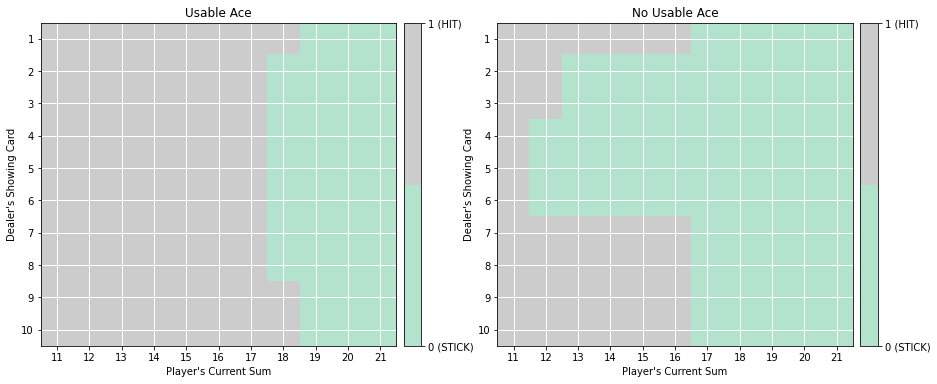

In [ ]:
# plot the optimal policy
plot_policy(optimal_policy)

In [ ]:
# 이 함수는 위에 주어진 optimal policy와 똑같은 행동을 만드는 정책을 state 별로 뽑아 비교 후 같으면 score를 높여준다.
def score(policy):
    point = 0
    for key, value in optimal_policy.items():
        if key in policy and policy[key] == value:
            point += 1
    return point

In [ ]:
# 모든 정책이 optimal policy와 같다면 dealer showing 10 * player sum 11 * ace 가능/불가능 2 = 220 개의 모든 state에 대해서 점수를 받아 220점이다.
score(optimal_policy)

220

In [ ]:
score(policy_glie)

194

기존의 policy_glie는 194점 (나중에 다시 돌리면서 다른 점수가 나올 수 있다.) 이라 부족함이 있다.

아래에 수정된 알고리즘이다. 모수를 늘리고 epsilon을 수업시간에 GLIE에서 다룬 것으로 바꿨다. 모수 많이 하는 것 오래걸리니까 다시 검토할 때 다시 돌려서 출력 삭제하지 않도록 조심할 것.

In [ ]:
# GLIE 조건으로 무한히 (충분히) 각 상태와 행동을 해보고
# 학습된 optimal action을 확률 1로 얻어야 하니까 epsilon을 1/t 로 가져가겠다.
# 이때 GLIE가 되는데, 실제로 무한히 해서 t -> inf 하게는 못하지만 최대한 크게 가져간다.
def mc_control_GLIE_overtime(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
        # determine the policy corresponding to the final action-value function estimate
        policy = dict((k,np.argmax(v)) for k, v in Q.items())
        if score(policy) > 200:
            break
    return policy, Q

In [ ]:
# 실제로 t -> inf는 아니까 more glie라고 하겠다.
# 오래걸리니까 한번만 돌린다.
policy_more_glie, Q_glie = mc_control_GLIE_overtime(env, 500000 * 2 ** 3)

Episode 4000000/4000000.

In [ ]:
score(policy_more_glie)

136

1시간 돌려서 생각보다 너무 낮은 점수가 나왔다. score 확인할 수 있게 돌려보면 처음 수천번 내로 130대로 진입하고 거기서 더이상 성장하지 못한다. epsilon의 힘이 너무 강하다.

이론적으로 epsilon이 1/t이면 GLIE라서 optimal 값을 갖지만 학습이 너무 오래 걸리는 것으로 보인다.

In [ ]:
from numpy.lib.polynomial import polyint
def mc_control_GLIE_sufficient(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            point = score(policy)
            print("\rEpisode {}/{} and score is {}.".format(i_episode, num_episodes, point), end="")
            sys.stdout.flush()
            if point > 200:
                break
        # set the value of epsilon
        epsilon = 1.0/((i_episode/16000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
        # determine the policy corresponding to the final action-value function estimate
        policy = dict((k,np.argmax(v)) for k, v in Q.items())
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

학습하면서 score를 계산하니까 너무 오래 걸리고 또 중간중간 지금 학습을 잘 하고 있는지 확인을 할 수가 없어서 Episode iteration 표기에 이를 넣었다. 단순히 모수 늘리는 것은 두배 넘게 해도 쉽지가 않았다. 190 후반에서 막힌다. 물론 모수를 계속 늘리면 policy가 개선이 되지만 epsilon 값을 더 크게 두었다. (16000/t)

In [ ]:
policy_sufficient_glie, Q_glie = mc_control_GLIE_sufficient(env, 500000 * 2 ** 3)

Episode 582000/4000000 and score is 201.

score를 적용하여 학습이 이루어지는 것을 관찰했다. 모수 약간 늘렸고 (582000) epsilon 두배로 해서 후반부에 학습하는 효율을 높였다. 대신 초반에는 좀 휘청거리는데, 결국 중요한 것은 학습이 끝난 후니까 결과가 나아졌다. 이와 같은 결과를 고려하면 epsilon을 초반에는 작게하고 후반에는 크게하는 것이 괜찮은 방법으로 보인다.

### Part 4: MC Control: Constant learning rate $\alpha$

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = 1.0/((i_episode)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

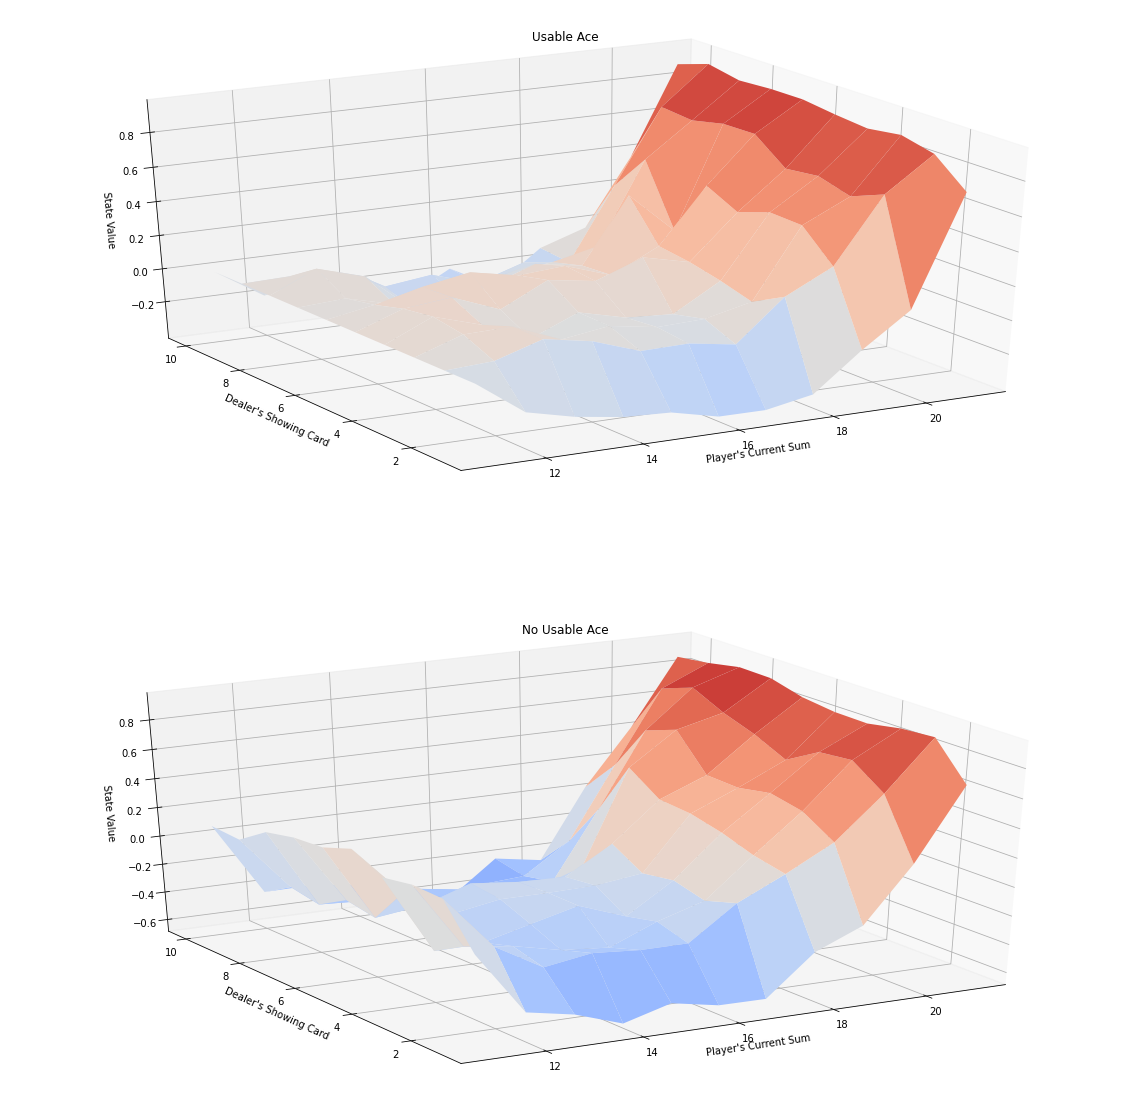

In [ ]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

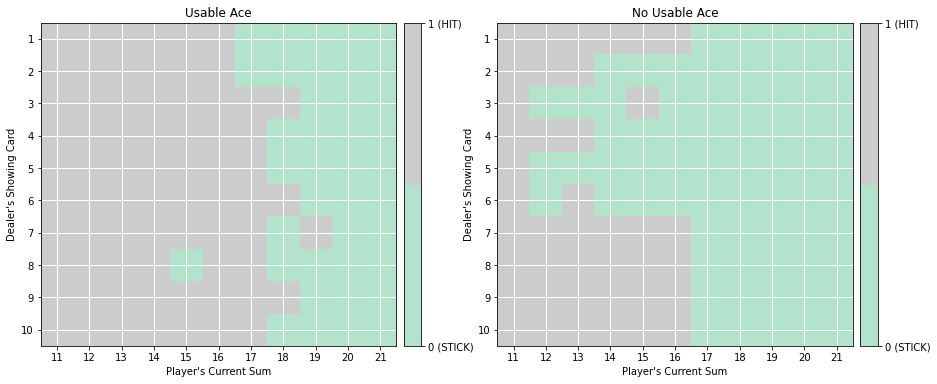

In [ ]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](https://github.com/harshitandro/OpenAI-Gym-BlackjackEnv/blob/master/Monte_Carlo/images/optimal.png?raw=1)

지금 주어진 alpha가 기존의 N보다 성능이 좋은지 나쁜지를 파악하고 2배 크게, 2배 작게해서 경향성을 보고 가장 좋은 성능을 만들어내는 alpha 값을 찾겠다.

In [ ]:
score(policy_alpha)

196

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_alpha05, Q_alpha = mc_control_alpha(env, 500000, 0.004)
score(policy_alpha05)

Episode 500000/500000.

198

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_alpha025, Q_alpha = mc_control_alpha(env, 500000, 0.008 * 0.25)
score(policy_alpha025)

Episode 500000/500000.

197

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_alpha3, Q_alpha = mc_control_alpha(env, 500000, 0.016)
score(policy_alpha3)

Episode 500000/500000.

202

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_alpha4, Q_alpha = mc_control_alpha(env, 500000, 0.008 * 4)
score(policy_alpha4)

Episode 500000/500000.

199

alpha를 두배로 했더니 optimal에 조금 더 가까운 결과를 냈다. 4배로 올리니 오히려 score가 떨어져서 적절한 결과를 얻은 것은 policy_alpha3이다.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy_alpha3, Q_alpha = mc_control_alpha(env, 500000, 0.016)
score(policy_alpha3)

Episode 500000/500000.

197

다시 값을 얻고 확인하고 그려서 결과를 확인한다.

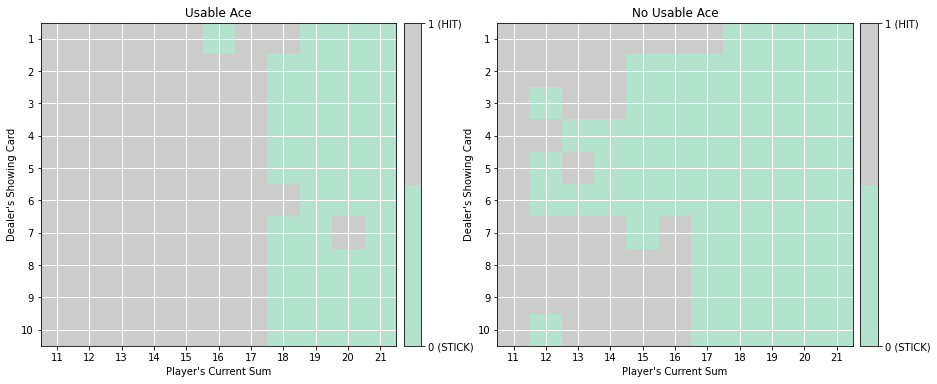

In [ ]:
# plot the policy
plot_policy(policy_alpha3)